# Student: Ta Quoc Viet (299954)

# Task 1

We have to do clustering on the jain data set (`jain.txt`):


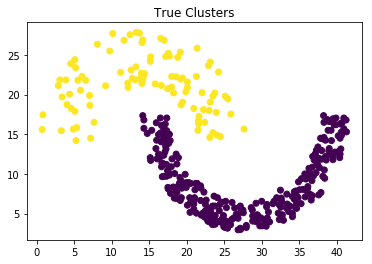

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import time
% matplotlib inline

JAIN_DATA_PATH = './ex3/jain.txt'
data = np.loadtxt(JAIN_DATA_PATH)


def show_clustering(X, Y, centroids=None, title=None, c=None):
    plt.scatter(X, Y, c=c)
    plt.title(title)
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red')


points = data[:, :2]
show_clustering(data[:, 0], data[:, 1], None, title='True Clusters', c=data[:, 2])
plt.show()


## K-means clustering

Time taken with K-means clustering = 0.158s
Number of missed classifications = 80.0


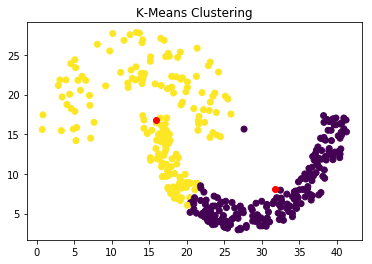

In [156]:
def kmeans(X, number_of_clusters=2):
    centroids = X[np.random.randint(0, len(X), size=(number_of_clusters,))]
    for i in range(20):
        # Cluster Assignment step
        C = np.array([np.argmin([np.dot(x_i - y_k, x_i - y_k) for y_k in centroids])
                      for x_i in X])
        # Move centroids step
        centroids = [X[C == k].mean(axis=0) for k in range(number_of_clusters)]
    return C, centroids
        
        
start = time.time()

C, centroids = kmeans(points)

end = time.time()
print('Time taken with K-means clustering = {:.3f}s'.format(end - start))

missed_points = np.sum(np.abs(C + 1 - data[:, 2]))
print('Number of missed classifications = {}'.format(missed_points))
show_clustering(data[:, 0], data[:, 1], np.array(centroids), title='K-Means Clustering', c=C)
plt.show()


The K-means algorithm need the number of clusters to start with, the initial centroid selection will also affect the final clustering result.

## Mountain Clustering

Time taken with Mountain clustering = 4.972s
Number of missed classifications = 27.0


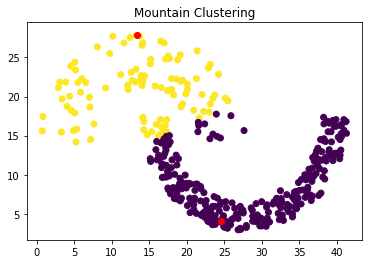

In [146]:
import math
from itertools import product

def mountain_func(V, X, sigma):
    return np.array(
        [np.sum([np.exp(-(np.square(np.linalg.norm(v_j - x_i))) / (2 * np.square(sigma)))
                 for x_i in X]) for v_j in V])


def destruct_mountain(M, V, c, beta):
    return np.array(
        [M[i] - M[c] * np.exp(-(np.square(np.linalg.norm(V[i] - V[c]))) / (2 * np.square(beta)))
         for i in range(len(M))])


def mountain(X, sigma, beta, number_of_peaks=2):
    x_min, x_max = math.floor(np.min(X[:, 0])), math.ceil(np.max(X[:, 0]))
    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
    x = np.linspace(x_min, x_max, int(x_max - x_min))
    y = np.linspace(y_min, y_max, int(y_max - y_min))
    grid_points = np.array(list(product(x, y)))
    centers = []
    M = mountain_func(grid_points, X, sigma)
    while len(centers) < number_of_peaks:
        center_index = np.argmax(M)
        centers.append(center_index)
        M = destruct_mountain(M, grid_points, center_index, beta)
    centroids = [grid_points[c] for c in centers]
    C = np.array([np.argmin([np.dot(x_i - y_k, x_i - y_k) for y_k in centroids]) for x_i in points])
    return C, centroids


start = time.time()
SIGMA = 0.2
BETA = 10
C, centroids = mountain(points, SIGMA, BETA)
end = time.time()
print('Time taken with Mountain clustering = {:.3f}s'.format(end - start))
missed_points = np.sum(np.abs(C + 1 - data[:, 2]))
print('Number of missed classifications = {}'.format(missed_points))

show_clustering(data[:, 0], data[:, 1],
                centroids=np.array(centroids), title='Mountain Clustering', c=C)
plt.show()


There're several paramenters that can affect the Mountain Clustering algorithm:
- Similar to k-means, mountain clustering also need number of clusters (peaks) to start clustering.
- $\sigma \rightarrow$ determine the smoothness of the mountains[1]. After several trials ($\sigma\in\{0.2, 0.5, 1, 2\}$), I found the with $\sigma=0.2$ the algorithm performed the best.
- $\beta$ is also required for the algorithm to work, I tried it with $\{1, 5, 10\}$ and $10$ performed the best.
- The smoothness of the grid also define the correctness of the clustering, but increasing it will increase the computational time hugely.

## Subtractive Clustering

Time taken with Subtracting clustering = 2.036s
Number of missed classifications = 40.0


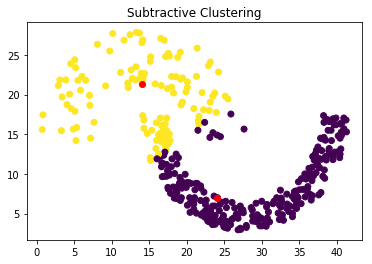

In [139]:
def density_measure(X, r_a):
    return np.array(
        [np.sum([np.exp(-(np.square(np.linalg.norm(x_i - x_j))) / (np.square(r_a / 2)))
                 for x_j in X]) for x_i in X])


def revised_density(D, X, c, r_b):
    return np.array(
        [D[i] - D[c] * np.exp(-(np.square(np.linalg.norm(X[i] - X[c]))) / (np.square(r_b / 2)))
         for i in range(len(D))])


def subtractive_clustering(X, r_a, r_b, number_of_clusters=2):
    centers = []
    D = density_measure(X, r_a)
    while len(centers) < number_of_clusters:
        center_index = np.argmax(D)
        centers.append(center_index)
        D = revised_density(D, X, center_index, r_b)
    centroids = X[centers]
    C = np.array([np.argmin([np.dot(x_i - y_k, x_i - y_k) for y_k in centroids]) for x_i in points])
    return C, centroids
    
    
start = time.time()
R_A = 20
R_B = 30
C, centroids = subtractive_clustering(points, R_A, R_B)
end = time.time()
print('Time taken with Subtracting clustering = {:.3f}s'.format(end - start))
missed_points = np.sum(np.abs(C + 1 - data[:, 2]))
print('Number of missed classifications = {}'.format(missed_points))
show_clustering(data[:, 0], data[:, 1],
                centroids=np.array(centroids), title='Subtractive Clustering', c=C)
plt.show()


There're several paramenters that can affect the Subtractive Clustering algorithm:
- $r_a$ determines the neighborhood area, data points outside this radius contribute only slightly to the density measure.[2].
- $r_b$ defines a neighborhood that has measurable reductions in density measure. Normally, $r_b = 1.5r_a$.[2].
- After several trials, I found the pair $(r_a, r_b) = \{20, 30\}$ performed the best.

# Task 2


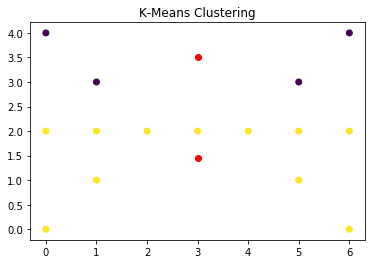

[array([5.2, 1.4]), array([1., 2.]), array([5.5, 3.5])]


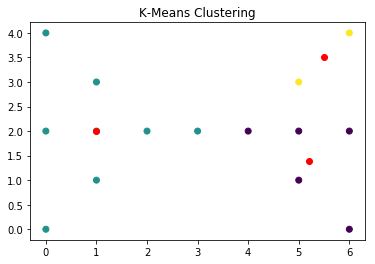

In [157]:
BUTTERFLY_DATA_PATH = './ex3/butterfly.txt'
butterfly_data = np.loadtxt(BUTTERFLY_DATA_PATH)

C, centroids = kmeans(butterfly_data)
show_clustering(butterfly_data[:, 0], butterfly_data[:, 1],
                centroids=np.array(centroids), title='K-Means Clustering', c=C)
plt.show()


C, centroids = kmeans(butterfly_data, number_of_clusters=3)
show_clustering(butterfly_data[:, 0], butterfly_data[:, 1],
                centroids=np.array(centroids), title='K-Means Clustering', c=C)
plt.show()

# References
[ [1] A mountain means clustering algorithm](https://ieeexplore.ieee.org/document/4593748)

[2] Veronica S. Moertini, INTRODUCTION TO FIVE DATA CLUSTERING ALGORITHMS